In [1]:
!pip install fastf1

  Using cached fastf1-3.5.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached requests_cache-1.2.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached timple-0.1.8-py3-none-any.whl.metadata (2.0 kB)
  Using cached websockets-13.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled w

### Importing Libraries

In [2]:
import fastf1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
fastf1.Cache.enable_cache('/tmp')

### Data preprocessing

In [4]:
def extract_data(year, gp_name):
  race_session = fastf1.get_session(year, gp_name, 'R')
  race_session.load()

  quali_session = fastf1.get_session(year, gp_name, 'Q')
  quali_session.load()

  laps = race_session.laps.copy()
  weather = race_session.weather_data.copy()
  results = race_session.results
  qualis = quali_session.results

  laps.sort_values('LapStartTime', inplace=True)
  weather.sort_values('Time', inplace=True)

  laps = pd.merge_asof(laps, weather, left_on='LapStartTime', right_on='Time', direction='nearest')
  laps = laps[laps['IsAccurate'] & ~laps['PitInTime'].notnull() & ~laps['PitOutTime'].notnull()]

  data = []
  for driver in race_session.drivers:
    driver_info = race_session.get_driver(driver)

    driver_laps = laps[laps['DriverNumber'] == driver]
    if driver_laps.empty or driver not in results['DriverNumber'].values:
        continue

    race_result = results[results['DriverNumber'] == driver]
    quali_result = qualis[qualis['DriverNumber'] == driver]

    finish_position = race_result['Position'].values[0]
    grid_position = race_result['GridPosition'].values[0]

    lap_times = driver_laps['LapTime'].dt.total_seconds()

    data.append({
            'year': year,
            'GP': gp_name,
            'DriverNumber': int(driver),
            'LapTimeMean': lap_times.mean(),
            'LapTimeStd': lap_times.std(),
            'AirTempMean': driver_laps['AirTemp'].mean(),
            'HumidityMean': driver_laps['Humidity'].mean(),
            'TrackTempMean': driver_laps['TrackTemp'].mean(),
            'WindSpeedMean': driver_laps['WindSpeed'].mean(),
            'PressureMean': driver_laps['Pressure'].mean(),
            'Rainfall': driver_laps['Rainfall'].mean(),
            'Q1': pd.to_timedelta(quali_result['Q1'].values[0]).total_seconds() if pd.notnull(quali_result['Q1'].values[0]) else np.nan,
            'Q2': pd.to_timedelta(quali_result['Q2'].values[0]).total_seconds() if pd.notnull(quali_result['Q2'].values[0]) else np.nan,
            'Q3': pd.to_timedelta(quali_result['Q3'].values[0]).total_seconds() if pd.notnull(quali_result['Q3'].values[0]) else np.nan,
            'GridPosition': grid_position,
            'FinishPosition': finish_position
    })

  return pd.DataFrame(data)

In [5]:
country = 'Monaco'

In [6]:
data_2024 = extract_data(2024, country)
data_2023 = extract_data(2023, country)
data_2022 = extract_data(2022, country)

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_dat

In [7]:
training_data = pd.concat([data_2024, data_2023, data_2022], axis=0)

In [8]:
X = training_data.drop(columns=['year', 'GP', 'FinishPosition', 'LapTimeMean'])
y = training_data['FinishPosition']

In [9]:
X = pd.get_dummies(X, columns=['DriverNumber'])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
features_to_scale = ['AirTempMean', 'HumidityMean', 'TrackTempMean', 'WindSpeedMean', 'PressureMean', 'Rainfall', 'LapTimeStd', 'Q1', 'Q2', 'Q3', 'GridPosition']

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train[features_to_scale] = sc.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = sc.transform(X_test[features_to_scale])

### Random Forest Regression

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=400)

In [14]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f} Positions")

Test RMSE: 2.7732 Positions


### XGBoost Regression

In [15]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=300, learning_rate = 0.01, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
y_pred = xgb.predict(X_test)

In [17]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f} Positions")

Test RMSE: 2.9335 Positions


### Predicting The race results Based on XGB Model

In [18]:
session = fastf1.get_session(2025, country, 'R')
session.load()

driver_name_map = {}
for drv in session.drivers:
    info = session.get_driver(drv)
    driver_name_map[int(drv)] = f"{info['FirstName']} {info['LastName']}"

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_dat

In [19]:
def predict_final_positions_from_drivers(driver_numbers, quali_data, weekend_data, expected_conditions, xgb_model, scaler, X_train_columns):

    drivers_info = []

    for number in driver_numbers:
        try:
            qdata = quali_data[quali_data['DriverNumber'] == number].iloc[0]
            wdata = weekend_data[weekend_data['DriverNumber'] == number].iloc[0]

            drivers_info.append({
                'DriverNumber': number,
                'Q1': qdata['Q1'],
                'Q2': qdata['Q2'],
                'Q3': qdata['Q3'],
                'GridPosition': wdata['GridPosition'],
                **expected_conditions
            })
        except IndexError:
            print(f"Warning: Missing data for Driver {number}, skipping.")
            continue

    if not drivers_info:
        return []

    df = pd.DataFrame(drivers_info)
    driver_nums = df['DriverNumber'].copy()

    df = pd.get_dummies(df, columns=['DriverNumber'])

    for col in X_train_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[X_train_columns]

    features_to_scale = ['AirTempMean', 'HumidityMean', 'TrackTempMean', 'WindSpeedMean', 'PressureMean', 'Rainfall', 'LapTimeStd', 'Q1', 'Q2', 'Q3', 'GridPosition']
    df[features_to_scale] = scaler.transform(df[features_to_scale])

    preds = xgb_model.predict(df)
    result_df = pd.DataFrame({'DriverNumber': driver_nums, 'Prediction': preds})

    result_df = result_df.sort_values(by='Prediction').reset_index(drop=True)

    return result_df


In [23]:
data_2025 = extract_data(2025, country)

expected_conditions = {
    'AirTempMean': data_2025['AirTempMean'].mean(),
    'HumidityMean': data_2025['HumidityMean'].mean(),
    'TrackTempMean': data_2025['TrackTempMean'].mean(),
    'WindSpeedMean': data_2025['WindSpeedMean'].mean(),
    'Rainfall': data_2025['Rainfall'].mean(),
    'PressureMean': data_2025['PressureMean'].mean()
}

driver_numbers = [4, 16, 81, 1, 44, 6, 31, 30, 23, 55, 63, 87, 43, 5, 18, 27, 22, 12, 14, 10]

predict_df = predict_final_positions_from_drivers(driver_numbers, data_2025, data_2025, expected_conditions, rf, sc, X_train.columns)

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           

In [25]:
predict_df = predict_df.sort_values(by='Prediction').reset_index(drop=True)
predict_df['PredictedFinishPosition'] = predict_df.index + 1
predict_df['DriverName'] = predict_df['DriverNumber'].map(driver_name_map)

final_results = predict_df[['PredictedFinishPosition', 'DriverName']]

print("Predicted Results: \n\n")
final_results[:10]

Predicted Results: 




,PredictedFinishPosition,DriverName
0,1,Lando Norris
1,2,Charles Leclerc
2,3,Oscar Piastri
3,4,Max Verstappen
4,5,Isack Hadjar
5,6,Fernando Alonso
6,7,Lewis Hamilton
7,8,Esteban Ocon
8,9,Liam Lawson
9,10,Alexander Albon


### Real Race Results - Monaco GP 2025

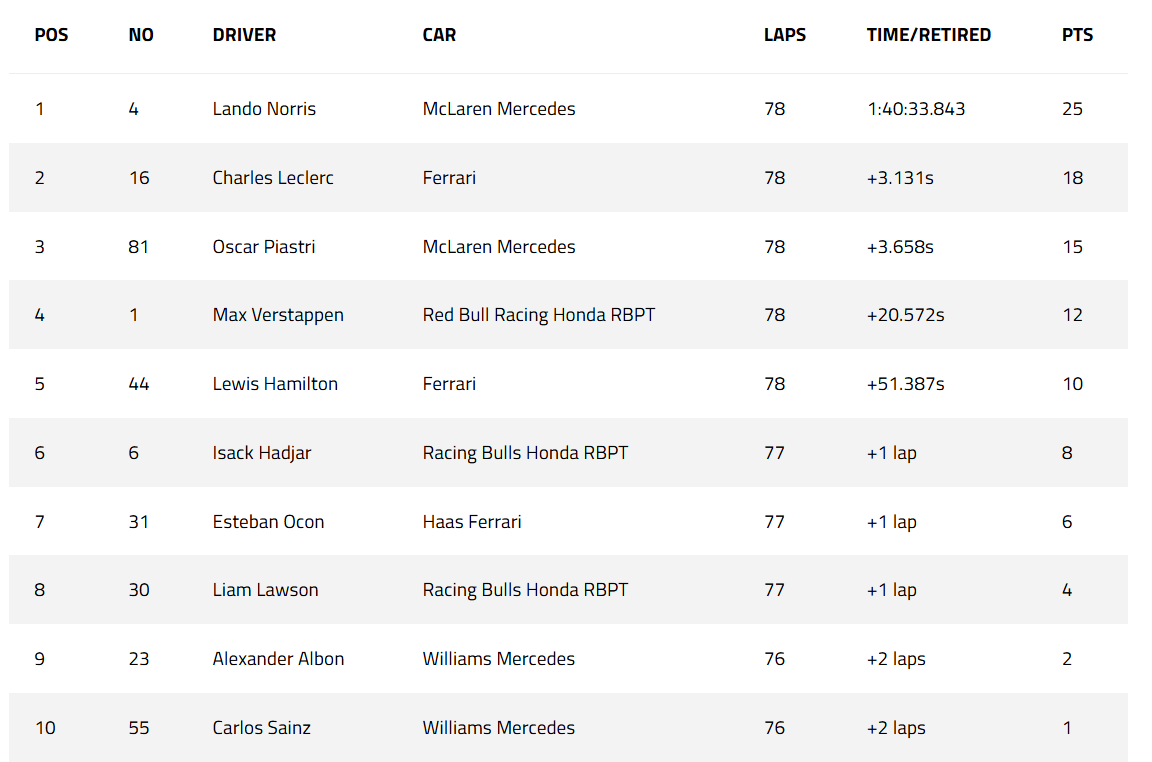